# Grad-CAM and Integrated Gradients

<br>

In this notebook we explore two applications of gradients in the context of deep learning, namely Grad-CAM and Integrated Gradients (IG).

- **Grad-CAM** (Gradient-weighted Class Activation Mapping) is a visualization technique that helps us understand which parts of an input image are most important for a neural network's prediction. 
<br>

- **Integrated Gradients (IG)** is a technique used to attribute the predictions of a neural network to its input features by integrating gradients along the path from a baseline input (e.g., a black image) to the actual input. 

<div align="center">
  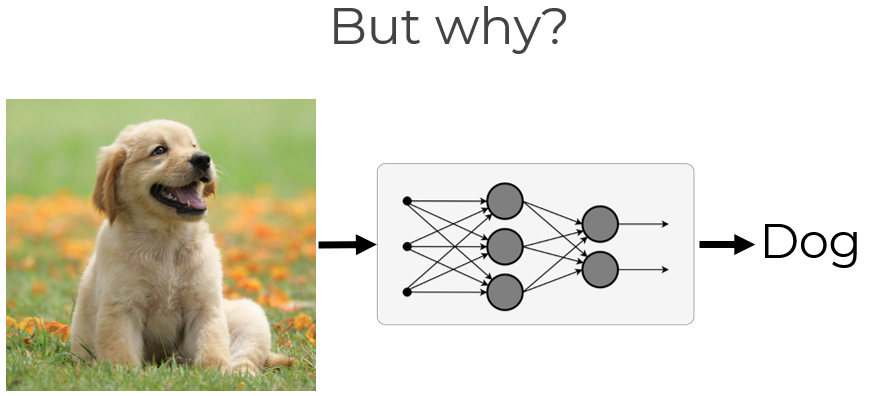
</div>

In [1]:
from torchvision import transforms
from typing import Tuple, Optional
from pathlib import Path
from torch import Tensor
from PIL import Image

import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torchvision
import torch
import json
import cv2
import os

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Setting up the model - ResNet34

In [3]:
model = torchvision.models.resnet34(weights='DEFAULT')

model = model.to(device)
model = model.eval()

In [4]:
target_layer = model.layer4[-1]

## Helpers 

In [5]:
def preprocess_image(image: Image.Image) -> Tensor:
    preprocessing = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    
    return preprocessing(image).unsqueeze(0)

In [6]:
def display(
    image: Image.Image, 
    heatmap: np.ndarray, 
    figsize: Tuple[int, int] = (5, 5), 
    cmap: str = 'jet',
    alpha: float = 0.6,
) -> None:
    
    if len(heatmap.shape) == 3:
        heatmap = heatmap[0]
        
    cmap = cv2.COLORMAP_JET if cmap == 'jet' else cv2.COLORMAP_INFERNO
    image = np.array(image)
    
    plt.subplots(figsize=figsize)
    plt.axis('off')
    
    explanation = cv2.applyColorMap(np.uint8(255 * heatmap), cmap)
    explanation = cv2.cvtColor(explanation, cv2.COLOR_BGR2RGB)
    explanation = cv2.addWeighted(image, alpha, explanation, 1. - alpha, 0)
    explanation = explanation / np.max(explanation)
    explanation = np.uint8(255 * explanation)
    
    plt.imshow(explanation)
    plt.show()

# Integrated Gradients

In [7]:
def integral_approximation(gradients: Tensor) -> Tensor:
    """
    Computes integral approximation of gradients using the trapezoidal rule
    
    :param gradients: Gradients along the interpolation path (steps + 1, *input_shape).
    :return: Averaged gradients with the same shape as a single gradient Tensor.
    """
    grads = (gradients[:-1] + gradients[1:]) / 2.0  # Trapezoidal rule
    return grads.mean(dim=0)

$IntegratedGrads^{approx}_{i}(x)::=\overbrace{(x_{i}-x'_{i})}^\text{5.}\times \overbrace{\sum_{k=1}^{m}}^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m}}^\text{1.}\times(x - x'))}^\text{2.}}^\text{3.}}{\partial x_{i}} \times \overbrace{\frac{1}{m}}^\text{4.}$

1. Generate alphas $\alpha$

2. Generate interpolated images = $(x' + \frac{k}{m}\times(x - x'))$

3. Compute gradients between model $F$ output predictions with respect to input features = $\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i}}$

4. Integral approximation through averaging gradients = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$

5. Scale integrated gradients with respect to original image = $(x_{i}-x'_{i}) \times \text{integrated gradients}$. The reason this step is necessary is to make sure that the attribution values accumulated across multiple interpolated images are in the same units and faithfully represent the pixel importances on the original image.

In [8]:
class IntegratedGradients:
    
    def __init__(self, model: nn.Module, device: torch.device) -> None:
        self.model = model
        self.device = device
        
    def __call__(
        self, 
        input_tensor: Tensor, 
        baseline: Optional[Tensor] = None, 
        class_idx: Optional[int] = None,
        steps: int = 50
    ) -> np.ndarray:
        """
        Compute the attribution for a given input tensor
        
        :param input_tensor: Input of shape (1, C, H, W).
        :param baseline: Baseline input (default: zeros).
        :param class_idx: Target class index (default: predicted class).
        :param steps: Number of interpolation steps
        
        :return: Attribution mask of shape (1, H, W).
        """
        input_tensor = input_tensor.to(self.device)
        
        if class_idx is None:
            output = self.model(input_tensor)
            class_idx = output.argmax(dim=-1).item()

        if baseline is None:
            baseline = torch.zeros_like(input_tensor, device=self.device)
        
        # 1. Generate alphas
        alphas = torch.linspace(0, 1, steps + 1, device=self.device)
        
        # 2. Generate interpolated images
        scaled_inputs = [baseline + alpha * (input_tensor - baseline) for alpha in alphas]
        
        # 3. Compute gradients for each interpolated input
        gradients = []
        for scaled_input in scaled_inputs:
            # 3.1: Enable gradient computation
            scaled_input = scaled_input.requires_grad_(True)
            
            # 3.2: Clear previous gradients and compute model output
            self.model.zero_grad()
            output = self.model(scaled_input)
            
            # 3.3: Compute gradients of target class output
            score = output[0, class_idx]
            score.backward()
            
            # 3.4: Store gradients
            gradients.append(scaled_input.grad.detach().clone())
        
        # 4. Integral approximation through gradient averaging
        # 4.1: Concatenate gradients and compute average using trapezoidal rule
        gradients = torch.stack(gradients)  # Shape: (steps + 1, C, H, W)
        avg_gradients = integral_approximation(gradients)  # Trapezoidal rule
        
        # 5. Scale integrated gradients with respect to input difference
        integrated_gradients = (input_tensor - baseline) * avg_gradients
        
        # Post-processing: compute attribution mask
        attribution_mask = integrated_gradients.abs().sum(dim=1)
        return attribution_mask.cpu().data.numpy()

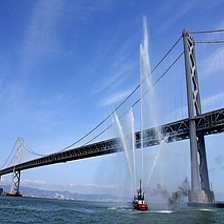

In [9]:
image = Image.open('data/fireboat.jpg').resize((224, 224))
input_tensor = preprocess_image(image)
image

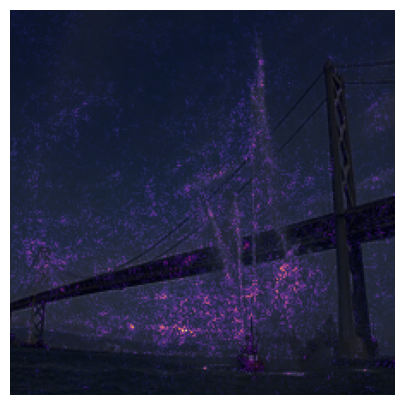

In [10]:
integrated_gradients = IntegratedGradients(model, device=device)
explanation = integrated_gradients(input_tensor, steps=50)
display(image, explanation, cmap='inferno', alpha=0.2)  # Explanation for class `fireboat`

# Activations and Gradients 

In [11]:
class ActivationsAndGradients:
    
    def __init__(self, model: nn.Module, target_layer: nn.Module) -> None:
        self.model = model
        self.gradients, self.activations = None, None
        
        self.hook_activations = target_layer.register_forward_hook(self.save_activation)
        self.hook_gradients = target_layer.register_forward_hook(self.save_gradient)
        
    def save_activation(self, module, input, output):
        self.activations = output.cpu().detach()
        
    def save_gradient(self, module, input, output):
        
        def _store_grad(grad):
            self.gradients = grad.cpu().detach()
    
        output.register_hook(_store_grad)
        
    def __call__(self, x: Tensor) -> Tensor:
        self.gradients, self.activations = None, None
        return self.model(x)
    
    def release(self):
        self.hook_activations.remove()
        self.hook_gradients.remove()

# Implementing Grad-CAM

One of the most important efforts in explaining the decision process of a deep convolutional neural network through a visual explanation is the methodology proposed in [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150) called Class Activation Mapping (CAM).

<div align="center">
  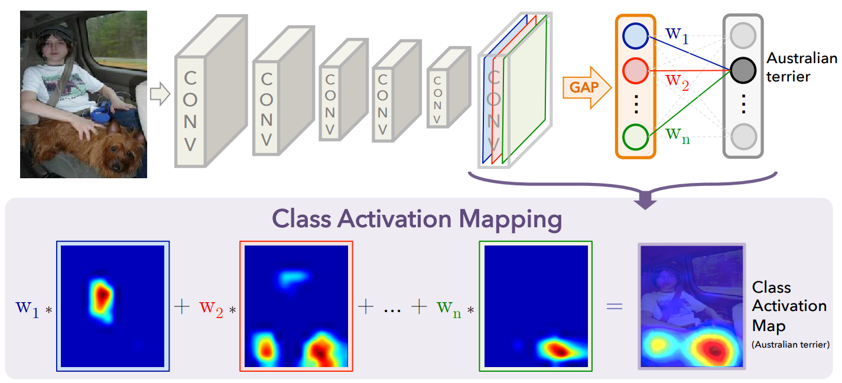
</div>

The idea of CAM is quite simple - the explanation for any input is just a linear combination of feature maps from a target layer (usually the last convolutional layer). Each feature map from the targeted activations is scaled by a score that should be representative of how important it was with regards to the final prediction (more important feature maps should have higher scores). 
By then summing up the scaled activation maps we obtain a single channel heatmap that highlights the salient areas in the ensuing activations. To then translate this to the original pixel space, we need to upscale this explanation to match the size of the input since, by design, its spatial resolution is limited to that of the activations from the targeted layer.

For **Grad-CAM** the scores are computed as the global mean of the gradients corresponding to the target layer. Henceforth, **Grad-CAM** only requires a single forward and backward pass to generate the explanation for a batch of inputs. 

In [12]:
class GradCAM:
    
    def __init__(self, model: nn.Module, target_layer: nn.Module, device: torch.device) -> None:
        
        self.model = model
        self.device = device
        self.activations_and_grads = ActivationsAndGradients(model, target_layer)
        
    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
    
    def normalize(self, cam: np.ndarray) -> np.ndarray:
        return np.float32([(x - x.min()) / (x.max() - x.min() + 1e-7) for x in cam])
    
    def scale(self, cam: np.ndarray, target_size: Tuple[int, int]) -> np.ndarray:
        return np.float32([cv2.resize(x, target_size) for x in cam])
        
    def __call__(self, input_tensor: Tensor, class_idx: Optional[int] = None) -> np.ndarray:
        """
        Compute Grad-CAM heatmap for a given input Tensor
        
        :param input_tensor: Input of shape (1, C, H, W).
        :param class_idx: Target class index (default: predicted class).
        
        :return: Heatmap of shape (1, H, W).
        """
        
        # Get the activations and gradients by running the input through the model
        # and running a backward pass (for the gradients)
        input_tensor = input_tensor.to(self.device)
        output = self.activations_and_grads(input_tensor)
        
        if class_idx is None:
            class_idx = np.argmax(output.cpu().data.numpy(), axis=-1)
        
        # Clear previous gradients and compute loss for target class
        self.model.zero_grad()
        loss = output[0, class_idx]
        
        # Run backward pass to compute gradients
        loss.backward(retain_graph=True)
    
        # Retrieve activations and gradients from the hooks
        activations = self.activations_and_grads.activations.cpu().data.numpy()
        gradients = self.activations_and_grads.gradients.cpu().data.numpy()
    
        # Compute Grad-CAM weights as the global average pooling of gradients
        weights = np.mean(gradients, axis=(2, 3))  # Global average pooling
        weights = weights.reshape(activations.shape[0], -1, 1, 1)  # Reshape for broadcasting
        
        # Construct the weighted sum of activations
        cam = np.sum(weights * activations, axis=1)  # Weighted combination of feature maps
        
        # Post process the heatmap
        cam = np.maximum(cam, 0)   # Only keep positive influences
        cam = self.normalize(cam)  # Normalize to [0, 1] range
        cam = self.scale(cam, input_tensor.shape[-2:])  # Scale to the size of the input

        return cam

# Explaining where the model looks in the image 

## Loading in an example to be explained 

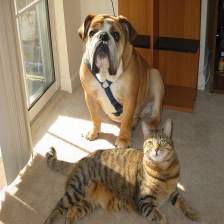

In [13]:
image = Image.open('data/dog_cat.png')
input_tensor = preprocess_image(image)
image

## Grad-CAM 

In [14]:
grad_cam = GradCAM(model, target_layer, device=device)

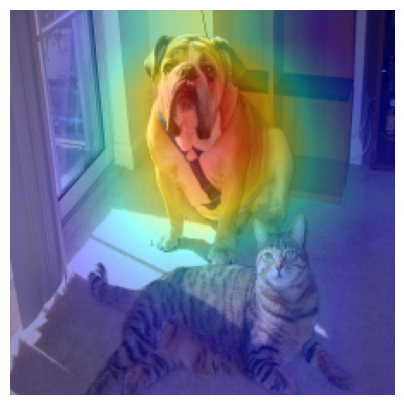

In [15]:
heatmap = grad_cam(input_tensor)  # output is of shape (1, 224, 224)
display(image, heatmap)  # Explanation for class `bull mastiff`

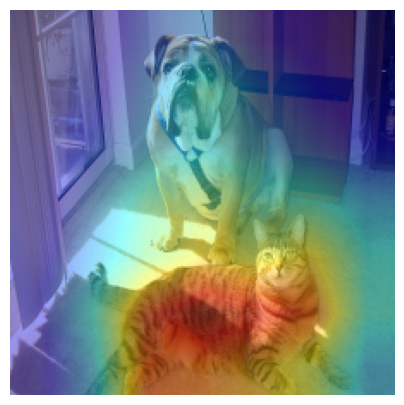

In [16]:
heatmap = grad_cam(input_tensor, class_idx=282)
display(image, heatmap)  # Explanation for class `tiger cat`